In [ ]:
%pip uninstall fc -y


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# if working in the sandbox, fc is already installed.
#%pip install --extra-index-url=https://packages.dea.ga.gov.au/ fc

%pip install git+https://github.com/GeoscienceAustralia/fc.git -q


  Cloning https://github.com/GeoscienceAustralia/fc.git to /tmp/pip-req-build-nqd2ohze
  Running command git clone --filter=blob:none --quiet https://github.com/GeoscienceAustralia/fc.git /tmp/pip-req-build-nqd2ohze
  Resolved https://github.com/GeoscienceAustralia/fc.git to commit f2a7481ae6cdf15ddea6aac93918830f9c55033e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import warnings
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from fc.fractional_cover import (
    fractional_cover,
)  # import the FC package after installing it above

from odc.geo.geom import Geometry
from collections import namedtuple
from datacube.model import Measurement

import sys

sys.path.insert(1, "/home/jovyan/dev/Tools/")
from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb

warnings.filterwarnings("ignore")


In [ ]:
client = create_local_dask_cluster(return_client=True)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 7,Total memory: 58.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36951,Workers: 1
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 58.90 GiB
Comm: tcp://127.0.0.1:39333,Total threads: 7
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/46177/status,Memory: 58.90 GiB
Nanny: tcp://127.0.0.1:35513,


In [ ]:
MEASUREMENTS = [
    {
        "name": "BS",
        "src_var": "BS",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Bare ground fraction percentage",
            "comment": "Fraction of bare ground including rock, bare and disturbed soil, within the Landsat pixel as percentages",
            "alias": "bare",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["bare"],
    },
    {
        "name": "PV",
        "src_var": "PV",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Green cover fraction percentage",
            "comment": "Fraction of green cover including green groundcover and green leaf material over all strata, within the Landsat pixel, as percentages",
            "alias": "green",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["green_veg"],
    },
    {
        "name": "NPV",
        "src_var": "NPV",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Non-green cover fraction percentage",
            "comment": "Fraction of non green cover including litter, dead leaf and branches over all strata, within the Landsat pixel, as percentages",
            "alias": "dead",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["dead_veg"],
    },
    {
        "name": "UE",
        "src_var": "UE",
        "units": "1",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Unmixing error",
            "comment": "Euclidean Norm of the Residual Vector",
            "alias": "err",
            "coverage_content_type": "qualityInformation",
        },
        "aliases": ["err"],
    },
]


In [ ]:
"""
You need to convert your MEASUREMENTS list of dicts into a list of objects that have a .name attribute.
If you want a quick fix, you can use a namedtuple:
"""

MEASUREMENTS_OBJ = [Measurement(**m) for m in MEASUREMENTS]


In [ ]:
SENSOR_REGRESSION_COEFFICIENTS = {
    "blue": [0.00041, 0.97470],
    "green": [0.00289, 0.99779],
    "red": [0.00274, 1.00446],
    "nir": [0.00004, 0.98906],
    "swir1": [0.00256, 0.99467],
    "swir2": [-0.00327, 1.02551],
}


In [ ]:
BAND_MAPPING = (
    {"load_bands": ("green", "red", "nir", "swir1", "swir2"), "rename": None},
    {
        "load_bands": (
            "nbart_green",
            "nbart_red",
            "nbart_nir",
            "nbart_swir_1",
            "nbart_swir_2",
        ),
        "rename": {
            "nbart_green": "green",
            "nbart_red": "red",
            "nbart_nir": "nir",
            "nbart_swir_1": "swir1",
            "nbart_swir_2": "swir2",
        },
    },
)


In [ ]:
# region_code = ['x176y085'] #marysville
# region_code = ['x168y092'] #hopetoun
# region_code = ['x140y138'] #west macdonnell
# region_codes = ['x148y166'] #limmen NT - cloud heavy area
# region_codes = ['x175y066'] # Tas SW nat park


region_codes = ["x176y085"]

time = ("2022-01-10", "2022-02-01")

resolution = (-30, 30)
filters_id = "test"
measurements = [
    "nbart_green",
    "nbart_red",
    "nbart_blue",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
]
# dask_chunks = dict(x=1024, y=1024, time=1)


In [ ]:
# open tiles and select

gdf = gpd.read_file(
    "~/gdata1/projects/fc-sub-annual/data/testing_minitile_suite.geojson"
)

gdf = gdf[gdf["region_code"].isin(region_codes)]

geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)


In [ ]:
dc = datacube.Datacube(app="fc_ls_test")

query = {
    "time": time,
    "measurements": measurements,
    "resolution": resolution,
    "geopolygon": geom,
    "dask_chunks": {},
    "group_by": "solar_day",
    "output_crs": "EPSG:3577",
}


In [ ]:
# gdf.explore(
#     tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#     attr='Esri',
#     name='Esri satellite'
# )


In [ ]:
ls_fc = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3"],
    cloud_mask="fmask",
    mask_pixel_quality=True,
    mask_contiguity=True,
    skip_broken_datasets=True,
    verbose=True,
    **query,
)


Finding datasets
    ga_ls8c_ard_3
Applying fmask pixel quality/cloud mask
Applying contiguity mask (oa_nbart_contiguity)
Returning 1 time steps as a dask array


In [ ]:
ls_fc


<xarray.Dataset> Size: 27MB
Dimensions:       (time: 1, y: 1068, x: 1067)
Coordinates:
  * time          (time) datetime64[ns] 8B 2022-01-20T00:03:39.124862
  * y             (y) float64 9kB -4.16e+06 -4.16e+06 ... -4.192e+06 -4.192e+06
  * x             (x) float64 9kB 1.216e+06 1.216e+06 ... 1.248e+06 1.248e+06
    spatial_ref   int32 4B 3577
Data variables:
    nbart_green   (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    nbart_red     (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

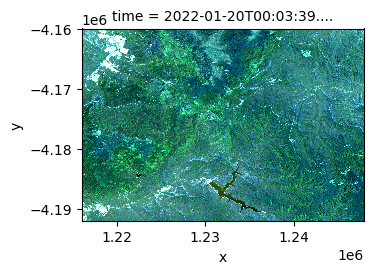

In [ ]:
rgb(ls_fc, bands=["nbart_blue", "nbart_green", "nbart_red"], col="time", size=3)


In [ ]:
def run_fc(nbart: xr.Dataset, measurements, regression_coefficients):
    input_tile = nbart.squeeze("time").drop("time")
    data = fractional_cover(input_tile, measurements, regression_coefficients)
    output_tile = unsqueeze_dataset(data, "time", nbart.time.values[0])
    return output_tile


In [ ]:
# # try building the config file like its done in fc_app

# config = {}

# for guess in BAND_MAPPING:
#     if set(guess["load_bands"]) <= set(measurements):
#         # These bands will work
#         config["load_bands"] = guess["load_bands"]
#         config["band_mapping"] = guess["rename"]
#         break

# config["nbart_product"] = "ga_ls8c_ard_3"
# config["measurements"] = measurements
# config["fc_product"] = "ga_ls8c_fc_3"
# config['sensor']


In [ ]:
for mapping in BAND_MAPPING:
    if mapping["rename"]:
        rename_dict = mapping["rename"]
        break

ls_fc_renamed = ls_fc.rename(rename_dict)


In [ ]:
ls_fc_renamed


<xarray.Dataset> Size: 27MB
Dimensions:      (time: 1, y: 1068, x: 1067)
Coordinates:
  * time         (time) datetime64[ns] 8B 2022-01-20T00:03:39.124862
  * y            (y) float64 9kB -4.16e+06 -4.16e+06 ... -4.192e+06 -4.192e+06
  * x            (x) float64 9kB 1.216e+06 1.216e+06 ... 1.248e+06 1.248e+06
    spatial_ref  int32 4B 3577
Data variables:
    green        (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    red          (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    nir          (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    swir1        (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
    swir2        (time, y, x) float32 5MB dask.array<chunksize=(1, 1068, 1067), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
ls_fc_2d = ls_fc_renamed.squeeze("time").drop("time")

ls_fc_2d


<xarray.Dataset> Size: 27MB
Dimensions:      (y: 1068, x: 1067)
Coordinates:
  * y            (y) float64 9kB -4.16e+06 -4.16e+06 ... -4.192e+06 -4.192e+06
  * x            (x) float64 9kB 1.216e+06 1.216e+06 ... 1.248e+06 1.248e+06
    spatial_ref  int32 4B 3577
Data variables:
    green        (y, x) float32 5MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
    red          (y, x) float32 5MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
    nbart_blue   (y, x) float32 5MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
    nir          (y, x) float32 5MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
    swir1        (y, x) float32 5MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
    swir2        (y, x) float32 5MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
# fc = fractional_cover(ls_fc_renamed, MEASUREMENTS, SENSOR_REGRESSION_COEFFICIENTS)

fc = fractional_cover(ls_fc_2d, MEASUREMENTS_OBJ, SENSOR_REGRESSION_COEFFICIENTS)


In [ ]:
fc


<xarray.Dataset> Size: 5MB
Dimensions:      (y: 1068, x: 1067)
Coordinates:
  * y            (y) float64 9kB -4.16e+06 -4.16e+06 ... -4.192e+06 -4.192e+06
  * x            (x) float64 9kB 1.216e+06 1.216e+06 ... 1.248e+06 1.248e+06
    spatial_ref  int32 4B 3577
Data variables:
    BS           (y, x) int8 1MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
    PV           (y, x) int8 1MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
    NPV          (y, x) int8 1MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
    UE           (y, x) int8 1MB dask.array<chunksize=(1068, 1067), meta=np.ndarray>
Attributes:
    crs:           PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["G...
    grid_mapping:  spatial_ref

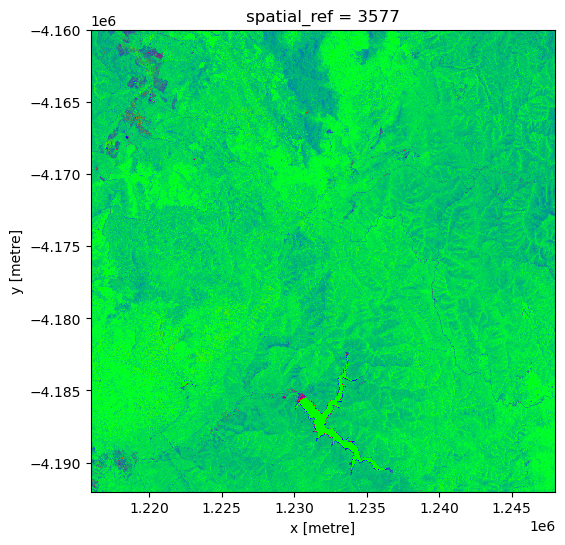

In [ ]:
rgb(fc, bands=["BS", "PV", "NPV"])


In [ ]:
# def fc_run_function(dc, geom, query, time, region_code):
#     # update the query to include our geometry
#     query.update({"geopolygon": geom})

#     # load available data from landsat
#     ls_fc = load_ard(
#         dc=dc,
#         products=["ga_ls9c_ard_3", "ga_ls8c_ard_3"],
#         cloud_mask="fmask",
#         mask_pixel_quality=True,
#         mask_contiguity=True,
#         skip_broken_datasets=True,
#         verbose=False,
#         **query,
#     )
#     # -----fractional-cover-----#

#     # -----export-tiles-----#
#     tiles_folder = f"/gdata/projects/fc-sub-annual/results/{filters_id}"
#     if not os.path.exists(tiles_folder):
#         os.makedirs(tiles_folder)
